# Import

In [ ]:
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from joblib import dump, load
from sklearn.utils.class_weight import compute_sample_weight

# Data importeren

Importeren van de data uit drive,
vul de authorization code in die verkregen wordt via de link of er wordt al direct een scherm opgebracht waar je kan inloggen.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/datasets" "/content/datasets"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
ln: failed to create symbolic link '/content/datasets/datasets': File exists


In [ ]:
import shutil
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_400_100_100.zip','.','zip')
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_1000_100_100_oversampling.zip','.','zip')
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_weightedsampling.zip','.','zip')
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_Mondriaan_220_55_55.zip','.','zip')
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_Mondriaan_1000_50_50.zip','.','zip')
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_Mondriaan_weightedsampling.zip','.','zip')

# classifying three painters

## Undersampling

### creëren datasets

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 1200 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


### Model

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.8192

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 20s 400ms/step - loss: 0.6879 - accuracy: 0.8192 - val_loss: 0.5659 - val_accuracy: 0.9100
Epoch 2/30
38/38 [==============================] - 14s 347ms/step - loss: 0.2116 - accuracy: 0.9208 - val_loss: 0.5877 - val_accuracy: 0.8900
Epoch 3/30
38/38 [==============================] - 15s 370ms/step - loss: 0.1713 - accuracy: 0.9408 - val_loss: 0.3140 - val_accuracy: 0.9233
Epoch 4/30
38/38 [==============================] - 15s 366ms/step - loss: 0.1433 - accuracy: 0.9583 - val_loss: 0.3019 - val_accuracy: 0.9333
Epoch 5/30
38/38 [==============================] - 14s 346ms/step - loss: 0.1169 - accuracy: 0.9583 - val_loss: 0.3039 - val_accuracy: 0.9233
Epoch 6/30
38/38 [==============================] - 15s 382ms/step - loss: 0.1208 - accuracy: 0.9583 - val_loss: 0.2803 - val_accuracy: 0.9233
Epoch 7/30
38/38 [==============================] - 15s 368ms/step - loss: 0.1228 - accuracy: 0.9550 - val_loss: 0.2358 - val_accuracy: 0.9233
Epoch 8/30

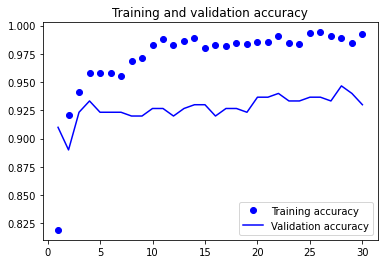

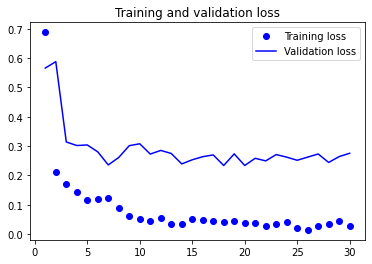

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 210ms/step - loss: 0.0658 - accuracy: 0.9833
Test accuracy: 0.983


## Oversampling

### creëren datasets

Doordat we nu aan oversampling doen zitten er bij classes Rubens en VanGogh dubbele images alleen bij de train dataset!!

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_1000_100_100_oversampling/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_1000_100_100_oversampling/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_1000_100_100_oversampling/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 3000 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


### Model

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
94/94 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8680

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


94/94 [==============================] - 35s 317ms/step - loss: 0.4829 - accuracy: 0.8680 - val_loss: 0.4339 - val_accuracy: 0.9067
Epoch 2/30
94/94 [==============================] - 29s 296ms/step - loss: 0.2054 - accuracy: 0.9363 - val_loss: 0.1862 - val_accuracy: 0.9467
Epoch 3/30
94/94 [==============================] - 28s 290ms/step - loss: 0.1589 - accuracy: 0.9463 - val_loss: 0.1961 - val_accuracy: 0.9433
Epoch 4/30
94/94 [==============================] - 29s 298ms/step - loss: 0.1342 - accuracy: 0.9593 - val_loss: 0.1456 - val_accuracy: 0.9633
Epoch 5/30
94/94 [==============================] - 29s 302ms/step - loss: 0.0969 - accuracy: 0.9637 - val_loss: 0.1423 - val_accuracy: 0.9667
Epoch 6/30
94/94 [==============================] - 29s 299ms/step - loss: 0.0685 - accuracy: 0.9733 - val_loss: 0.1418 - val_accuracy: 0.9567
Epoch 7/30
94/94 [==============================] - 28s 288ms/step - loss: 0.0786 - accuracy: 0.9710 - val_loss: 0.1658 - val_accuracy: 0.9533
Epoch 8/30

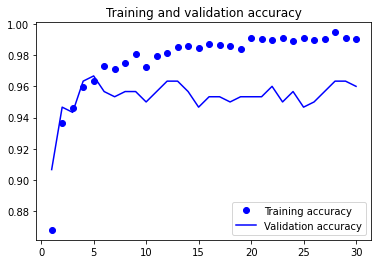

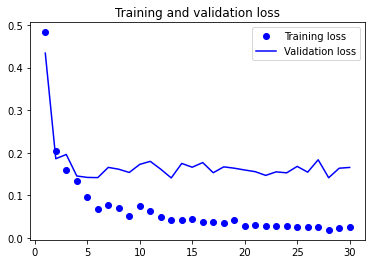

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 213ms/step - loss: 0.1254 - accuracy: 0.9700
Test accuracy: 0.970


## Weightedsampling

### creëren datasets

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_weightedsampling/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_weightedsampling/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_weightedsampling/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 1800 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


### Model

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

NameError: ignored

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

NameError: ignored

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

bepalen van de class weights:

In [ ]:
result = np.array([0.,0.,0.])
for image, label in train_dataset.take(57):
  result += np.sum(label.numpy(), axis=0)

print(result)

In [ ]:
class_weight = compute_sample_weight("balanced", result)

In [ ]:
class_weight = {i: class_weight[i] for i in range(len(class_weight))}
print(class_weight)

Nu worden deze weights meegegeven bij het fitten van het model.

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    class_weight=class_weight,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

# classifying four painters

## Undersampling

### creëren datasets

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_220_55_55/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_220_55_55/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_220_55_55/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 880 files belonging to 4 classes.
Found 220 files belonging to 4 classes.
Found 220 files belonging to 4 classes.


### Model

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=4,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 1.0423 - accuracy: 0.7591

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


28/28 [==============================] - 37s 490ms/step - loss: 1.0423 - accuracy: 0.7591 - val_loss: 0.7101 - val_accuracy: 0.8773
Epoch 2/30
28/28 [==============================] - 12s 376ms/step - loss: 0.4051 - accuracy: 0.8898 - val_loss: 0.3898 - val_accuracy: 0.9136
Epoch 3/30
28/28 [==============================] - 12s 373ms/step - loss: 0.2452 - accuracy: 0.9216 - val_loss: 0.2290 - val_accuracy: 0.9318
Epoch 4/30
28/28 [==============================] - 11s 343ms/step - loss: 0.1900 - accuracy: 0.9398 - val_loss: 0.2567 - val_accuracy: 0.9318
Epoch 5/30
28/28 [==============================] - 12s 371ms/step - loss: 0.1801 - accuracy: 0.9420 - val_loss: 0.2223 - val_accuracy: 0.9227
Epoch 6/30
28/28 [==============================] - 11s 342ms/step - loss: 0.1463 - accuracy: 0.9477 - val_loss: 0.2541 - val_accuracy: 0.9364
Epoch 7/30
28/28 [==============================] - 11s 342ms/step - loss: 0.1217 - accuracy: 0.9636 - val_loss: 0.2545 - val_accuracy: 0.9182
Epoch 8/30

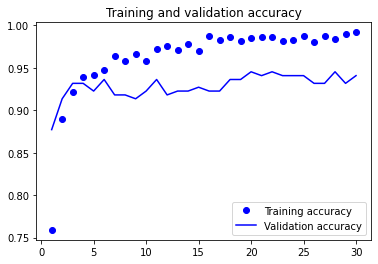

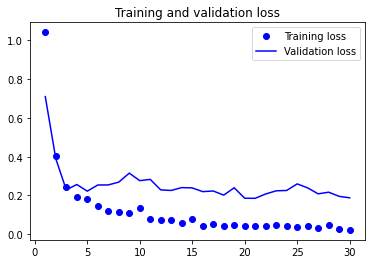

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 4s 215ms/step - loss: 0.2796 - accuracy: 0.9318
Test accuracy: 0.932


## Oversampling

### creëren datasets

Doordat we nu aan oversampling doen zitten er bij classes Rubens en VanGogh dubbele images alleen bij de train dataset!!

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_1000_50_50/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_1000_50_50/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_1000_50_50/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 4000 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.


### Model

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=4,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.8503

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


125/125 [==============================] - 42s 295ms/step - loss: 0.5283 - accuracy: 0.8503 - val_loss: 0.1951 - val_accuracy: 0.9500
Epoch 2/30
125/125 [==============================] - 36s 277ms/step - loss: 0.1973 - accuracy: 0.9325 - val_loss: 0.1032 - val_accuracy: 0.9650
Epoch 3/30
125/125 [==============================] - 35s 272ms/step - loss: 0.1541 - accuracy: 0.9510 - val_loss: 0.1047 - val_accuracy: 0.9650
Epoch 4/30
125/125 [==============================] - 36s 277ms/step - loss: 0.1095 - accuracy: 0.9607 - val_loss: 0.1025 - val_accuracy: 0.9600
Epoch 5/30
125/125 [==============================] - 36s 277ms/step - loss: 0.1153 - accuracy: 0.9615 - val_loss: 0.0869 - val_accuracy: 0.9750
Epoch 6/30
125/125 [==============================] - 35s 272ms/step - loss: 0.0905 - accuracy: 0.9657 - val_loss: 0.0994 - val_accuracy: 0.9650
Epoch 7/30
125/125 [==============================] - 35s 269ms/step - loss: 0.0746 - accuracy: 0.9735 - val_loss: 0.1079 - val_accuracy: 0.9

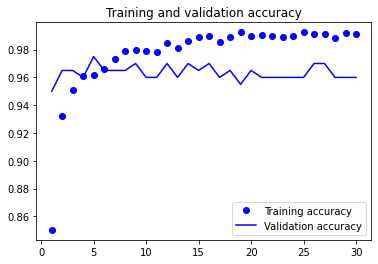

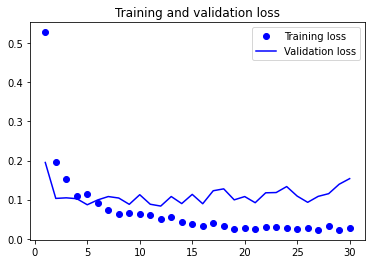

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 3s 196ms/step - loss: 0.1038 - accuracy: 0.9650
Test accuracy: 0.965


## Weightedsampling

### creëren datasets

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_weightedsampling/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_weightedsampling/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_weightedsampling/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 2730 files belonging to 4 classes.
Found 80 files belonging to 4 classes.
Found 80 files belonging to 4 classes.


### Model

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=4,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

bepalen van de class weights:

In [ ]:
result = np.array([0.,0.,0.,0.])
for image, label in train_dataset.take(len(train_dataset)):
  result += np.sum(label.numpy(), axis=0)
print(result)

[ 280. 1400.  350.  700.]


In [ ]:
class_weight = compute_sample_weight("balanced", result)
print(class_weight)

[1. 1. 1. 1.]


In [ ]:
class_weight = {i: class_weight[i] for i in range(len(class_weight))}
class_weight = {
    0:5.,
    1:1.,
    2:4.,
    3:2.
}

Nu worden deze weights meegegeven bij het fitten van het model.

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    class_weight=class_weight,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
86/86 [==============================] - ETA: 0s - loss: 1.8997 - accuracy: 0.7484

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


86/86 [==============================] - 30s 286ms/step - loss: 1.8997 - accuracy: 0.7484 - val_loss: 0.2314 - val_accuracy: 0.8875
Epoch 2/30
86/86 [==============================] - 24s 269ms/step - loss: 0.6413 - accuracy: 0.8597 - val_loss: 0.1469 - val_accuracy: 0.9625
Epoch 3/30
86/86 [==============================] - 24s 265ms/step - loss: 0.4566 - accuracy: 0.9059 - val_loss: 0.1260 - val_accuracy: 0.9500
Epoch 4/30
86/86 [==============================] - 24s 264ms/step - loss: 0.3668 - accuracy: 0.9212 - val_loss: 0.0948 - val_accuracy: 0.9625
Epoch 5/30
86/86 [==============================] - 23s 254ms/step - loss: 0.3231 - accuracy: 0.9289 - val_loss: 0.1027 - val_accuracy: 0.9500
Epoch 6/30
86/86 [==============================] - 25s 275ms/step - loss: 0.2973 - accuracy: 0.9311 - val_loss: 0.0678 - val_accuracy: 0.9875
Epoch 7/30
86/86 [==============================] - 23s 254ms/step - loss: 0.2796 - accuracy: 0.9355 - val_loss: 0.1392 - val_accuracy: 0.9750
Epoch 8/30

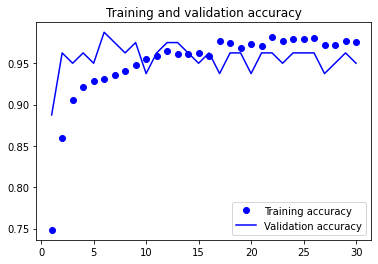

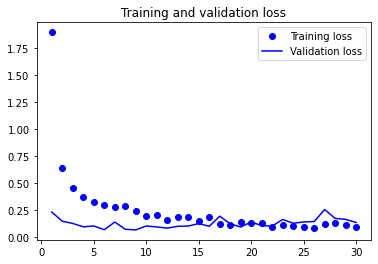

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

3/3 [==============================] - 2s 180ms/step - loss: 0.1387 - accuracy: 0.9375
Test accuracy: 0.938


#Besluit

classifying three painers
* Undersampling: accuracy=98.33%
* Oversampling: accuracy=97%
* Weightedsampling: accuracy=95.33%

classifying four painers
* Undersampling: accuracy=93.2%
* Oversampling: accuracy=96.5%
* Weightedsampling: accuracy=93.8%

Hier zien we dat undersampling nog steeds het best presteert bij een dataset waar er overal genoeg images zijn.

Wanneer we gaan classificeren met 4 verschillende painters en er een class bij zit met maar 200 images dan zien we dat oversampling beter wordt. Hierdoor zal ik voor multi class model met meer dan 4 classes de oversampling methode gebruiken.